In [335]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pyplot

In [381]:
# fonction plot
%pylab inline
import pylab
def gridplot(classifieur,train,test,n_points=50, classifier_type = 'gauss'):

    train_test = np.vstack((train,test))
    (min_x1,max_x1) = (min(train_test[:,0]),max(train_test[:,0]))
    (min_x2,max_x2) = (min(train_test[:,1]),max(train_test[:,1]))

    xgrid = np.linspace(min_x1,max_x1,num=n_points)
    ygrid = np.linspace(min_x2,max_x2,num=n_points)

	# calcule le produit cartesien entre deux listes
    # et met les resultats dans un array
    thegrid = np.array(combine(xgrid,ygrid))
    print thegrid.shape
    les_comptes = classifieur.compute_predictions(thegrid)
    
    classesPred = np.argmax(les_comptes,axis=1)+1

    # La grille
    # Pour que la grille soit plus jolie
    #props = dict( alpha=0.3, edgecolors='none' )
    pylab.scatter(thegrid[:,0],thegrid[:,1],c = classesPred, s=50, edgecolor='black', linewidth='1', label='grid')
	# Les points d'entrainment
    pylab.scatter(train[:,0], train[:,1], c = train[:,-1], marker = 'v', s=50,edgecolor='black', linewidth='1', label = 'train')
    # Les points de test
    pylab.scatter(test[:,0], test[:,1], c = test[:,-1], marker = 's', s=50,edgecolor='black', linewidth='1', label = 'test')

    ## Un petit hack, parce que la fonctionalite manque a pylab...
    h1 = pylab.plot([min_x1], [min_x2], marker='o', c = 'w',ms=1) 
    h2 = pylab.plot([min_x1], [min_x2], marker='v', c = 'w',ms=1) 
    h3 = pylab.plot([min_x1], [min_x2], marker='s', c = 'w',ms=1) 
    #handles = [h1,h2,h3]
    ## fin du hack

    labels = ['grille','train','test']
    #pylab.legend(handles=[h1,h2,h3],labels=['grille','train','test'])
    pylab.legend(loc=2, fontsize='small')
    pylab.axis('equal')
    pylab.show()

def combine(*seqin):
    '''returns a list of all combinations of argument sequences.
for example: combine((1,2),(3,4)) returns
[[1, 3], [1, 4], [2, 3], [2, 4]]'''
    def rloop(seqin,listout,comb):
        '''recursive looping function'''
        if seqin:                       # any more sequences to process?
            for item in seqin[0]:
                newcomb=comb+[item]     # add next item to current comb
                # call rloop w/ rem seqs, newcomb
                rloop(seqin[1:],listout,newcomb)
        else:                           # processing last sequence
            listout.append(comb)        # comb finished, add to list
    listout=[]                      # listout initialization
    rloop(seqin,listout,[])         # start recursive process
    return listout

Populating the interactive namespace from numpy and matplotlib


In [336]:
class gauss_density_estimator:
    def __init__(self,n_dims):
        self.mu = np.zeros((1,n_dims))
        self.n_dims = n_dims
        self.sigma_sq = np.ones(n_dims)
        
    def train(self, train_data):
        self.mu = np.mean(train_data, axis = 0)
        self.sigma_sq =  np.sum((train_data - self.mu) ** 2.0, axis = 0) / train_data.shape[0]
        
    def compute_predictions(self, test_data):
        c = -self.n_dims * np.log(2*np.pi)/2.0 - np.log(np.prod(self.sigma_sq))/2.0
        log_prob = c - np.sum((test_data -  self.mu)**2.0/ (2.0 * self.sigma_sq),axis=1)
        return log_prob

In [337]:
class parzen_estimator:
    def __init__(self,n_dims,h):
        self.n_dims = n_dims
        self.h = h
    def train(self, train_data):
        self.train_data = train_data
    
    #given a 1dimensional column vector input outputs the associated probabilities with each element in the column vector
    #given a multi-dimensional point, outputs the probability of that point
    #needs to be fixed to function as a consistent API interface
    def compute_predictions(self,x):
        constant = (1.0/self.train_data.shape[0])*(1/(np.power(np.sqrt(2*np.pi)*self.h,self.n_dims))) #scalar
        if self.n_dims == 1:
            prob = np.zeros_like(x)
            for i in range(len(x)):
                point = x[i]
                norm_diff = np.power(np.linalg.norm((point - self.train_data)[:,None],axis = 1),2.)
                prob[i] = np.sum(constant*(np.exp((-1)*(norm_diff)/(2*self.h**2))))
        else:
            norm_diff = np.power(np.linalg.norm((x - self.train_data),axis = 1),2.)
            prob = np.sum(constant*(np.exp((-1)*(norm_diff)/(2*self.h**2))))
        return prob

In [340]:
#given an input single column vector, outputs a single column vector of probabilities
#given a 2d point vector, outputs the probability at that point
def gaussian(x, mu, sig_sq):
    if x.shape[0] != 2:
        return (1/np.sqrt(2*np.pi*sig_sq))*np.exp(-np.power(x - mu, 2.) / (2 * sig_sq))
    else:
        return np.product((1/(np.sqrt(2*np.pi)*np.power(sig_sq, x.shape[0]/2.0)))*(np.exp((-np.transpose(x - mu)*(x-mu)))) / (2 * sig_sq))

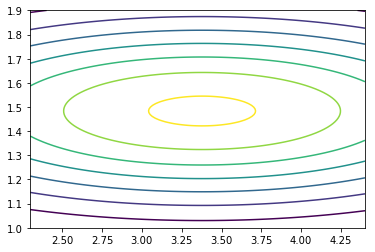

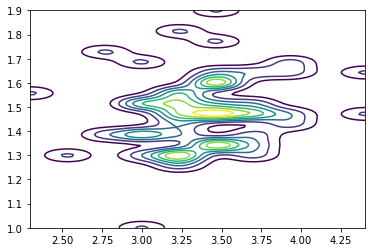

In [339]:
iris = np.loadtxt('iris.txt')
sizey = 120
class1_2d = iris[:50,[1,2]]
x = np.linspace(np.min(class1_2d[:,0]), np.max(class1_2d[:,0]), num = sizey)
y = np.linspace(np.min(class1_2d[:,1]), np.max(class1_2d[:,1]), num = sizey)
Zgauss = np.zeros((x.shape[0],y.shape[0]))
gaussian_2d = gauss_density_estimator(2)
gaussian_2d.train(class1_2d)

for i, val1 in enumerate(x):
    for j,val2 in enumerate(y):
        Zgauss[i,j] = gaussian(np.array([val1,val2]), gaussian_2d.mu, gaussian_2d.sigma_sq)
        
pyplot.contour(x,y,Zgauss)
pyplot.show()

parzen_2d = parzen_estimator(2,.05)
parzen_2d.train(class1_2d)
Z= np.zeros([sizey,sizey])
for i,val1 in enumerate(x):
    for j,val2 in enumerate(y):
        pointy = np.array([val1,val2])
        Z[i,j] = parzen_2d.compute_predictions(pointy)
        
pyplot.contour(x,y,Z)
pyplot.show()

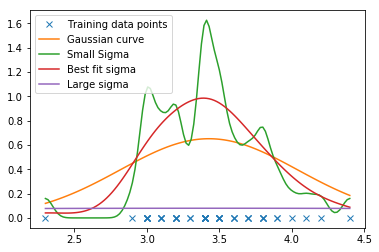

In [356]:
#3.3 a)
#Training data points
iris = np.loadtxt('iris.txt')
class1 = iris[:50,:]
class1_1d = iris[:50,1]
pyplot.plot(class1_1d, np.zeros_like(class1_1d)+0, 'x', label='Training data points')

#Gaussian curve
model = gauss_density_estimator(1)
model.train(class1_1d)
line = np.linspace(np.min(class1_1d), np.max(class1_1d), num=120)
y = gaussian(line,model.mu, np.sqrt(model.sigma_sq))
pyplot.plot(line,y, label='Gaussian curve')

#Small sigma
parzen_small = parzen_estimator(1,0.05)
parzen_small.train(class1_1d)
parzen_curve_small = parzen_small.compute_predictions(line)
pyplot.plot(line,parzen_curve_small, label='Small Sigma')

#Good fit sigma
parzen_fit = parzen_estimator(1,0.2)
parzen_fit.train(class1_1d)
parzen_curve_fit = parzen_fit.compute_predictions(line)
pyplot.plot(line,parzen_curve_fit, label='Best fit sigma')

#Small sigma
parzen_big = parzen_estimator(1,5)
parzen_big.train(class1_1d)
parzen_curve_big= parzen_big.compute_predictions(line)
pyplot.plot(line,parzen_curve_big, label = 'Large sigma')



pyplot.legend(loc=2)
pyplot.show()

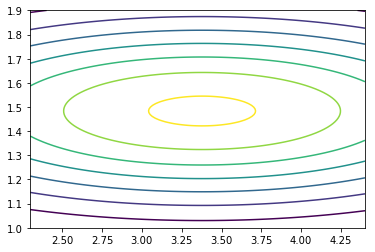

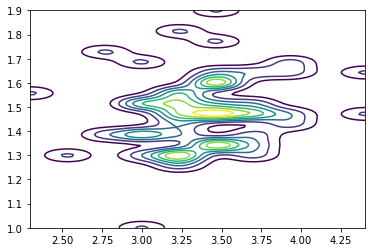

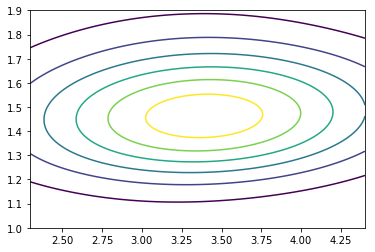

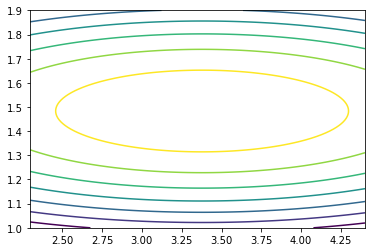

In [368]:
#3.4
iris = np.loadtxt('iris.txt')
sizey = 120
class1_2d = iris[:50,[1,2]]
dim1_space = np.linspace(np.min(class1_2d[:,0]), np.max(class1_2d[:,0]), num = sizey)
dim2_space = np.linspace(np.min(class1_2d[:,1]), np.max(class1_2d[:,1]), num = sizey)
Zgauss = np.zeros((dim1_space.shape[0],dim2_space.shape[0]))
gaussian_2d = gauss_density_estimator(2)
gaussian_2d.train(class1_2d)

for i, val1 in enumerate(dim1_space):
    for j,val2 in enumerate(dim2_space):
        Zgauss[i,j] = gaussian(np.array([val1,val2]), gaussian_2d.mu, gaussian_2d.sigma_sq)
        
pyplot.contour(x,y,Zgauss)
pyplot.legend()
pyplot.show()
hs = [0.05,.3,5]

for k in range(len(hs)):
    parzen_2d_small = parzen_estimator(2,hs[k])
    parzen_2d_small.train(class1_2d)
    Z= np.zeros([sizey,sizey])
    for i,val1 in enumerate(dim1_space):
        for j,val2 in enumerate(dim2_space):
            Z[i,j] = parzen_2d_small.compute_predictions(np.array([val1,val2]))
        
    pyplot.contour(x,y,Z)
    pyplot.show()

In [95]:
##Problem 4: Bayes Classifier

In [382]:
#Creating test and train groups
np.random.seed(123)
iris = np.loadtxt('iris.txt')
input_dims = [0,1,2,3]
split_ratio = 0.7
indices1 = np.arange(0,50)
indices2 = np.arange(50,100)
indices3 = np.arange(100,150)

np.random.shuffle(indices1)
np.random.shuffle(indices2)
np.random.shuffle(indices3)

split_index1 = int(split_ratio*len(indices1))
split_index2 = int(split_ratio*len(indices2))
split_index3 = int(split_ratio*len(indices3))

class1_train = iris[indices1[:split_index1]]
class1_test  = iris[indices1[split_index1:]]
class2_train = iris[indices2[:split_index2]]
class2_test  = iris[indices2[split_index2:]]
class3_train = iris[indices3[:split_index3]]
class3_test  = iris[indices3[split_index3:]]

gauss2d_class1 = gauss_density_estimator(2)
gauss2d_class2 = gauss_density_estimator(2)
gauss2d_class3 = gauss_density_estimator(2)

gauss2d_class1.train(class1_train[:,input_dims[:2]])
gauss2d_class2.train(class2_train[:,input_dims[:2]])
gauss2d_class3.train(class3_train[:,input_dims[:2]])

gauss4d_class1 = gauss_density_estimator(4)
gauss4d_class2 = gauss_density_estimator(4)
gauss4d_class3 = gauss_density_estimator(4)

gauss4d_class1.train(class1_train[:,input_dims[:4]])
gauss4d_class2.train(class2_train[:,input_dims[:4]])
gauss4d_class3.train(class3_train[:,input_dims[:4]])

iris_train = np.concatenate([class1_train, class2_train, class3_train])
iris_test = np.concatenate([class1_test, class2_test, class3_test])

In [383]:
#4.2 - Creating Bayes Gauss Classifier
class classif_bayes:

    def __init__(self,modeles_mv, priors):
        self.modeles_mv = modeles_mv
        self.priors = priors
        if len(self.modeles_mv) != len(self.priors):
            print 'Le nombre de modeles MV doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_mv)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle MV. 
    def compute_predictions(self, test_data, eval_by_group=False):
        log_pred = np.empty((test_data.shape[0],self.n_classes))

        for i in range(self.n_classes):
            # ici il va falloir utiliser modeles_mv[i] et priors pour remplir
            # chaque colonne de log_pred (c'est plus efficace de faire tout une
            # colonne a la fois)
            
            log_pred[:,i] = self.modeles_mv[i].compute_predictions(test_data) +  np.log(self.priors[i])

        return log_pred

(2500, 2)


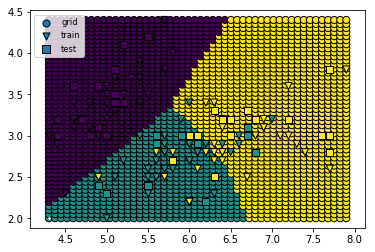

In [384]:
#4.2.b - 2D visualization of Bayes Classifier
bayesgauss2d = classif_bayes([gauss2d_class1,gauss2d_class2,gauss2d_class3],[0.333,0.333,0.333])
gridplot(bayesgauss2d, iris_train[:, input_dims + [-1]], iris_test[:, input_dims + [-1]], n_points=50)

In [385]:
#4.2.c Error Rates - 2D
log_prob_train=bayesgauss2d.compute_predictions(iris_train[:, input_dims[:2]])
log_prob_test=bayesgauss2d.compute_predictions(iris_test[:, input_dims[:2]])

classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

Taux d'erreur (entrainement) 20.00%
Taux d'erreur (test) 20.00%


In [386]:
#4.2.d Error Rates - 4D
bayesgauss4d  = classif_bayes([gauss4d_class1,gauss4d_class2,gauss4d_class3],[0.333,0.333,0.333])
log_prob_train=bayesgauss4d.compute_predictions(iris_train[:, input_dims[:4]])
log_prob_test=bayesgauss4d.compute_predictions(iris_test[:, input_dims[:4]])

classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

Taux d'erreur (entrainement) 4.76%
Taux d'erreur (test) 2.22%


In [314]:
#4.3 Creating Bayes Parzen Classifier
class classif_bayes_parzen:

    def __init__(self,modeles_mv, priors):
        self.modeles_mv = modeles_mv
        self.priors = priors
        if len(self.modeles_mv) != len(self.priors):
            print 'Le nombre de modeles MV doit etre egale au nombre de priors!'
        
        self.n_classes = len(self.modeles_mv)
                                                            
    # Retourne une matrice de taille nb. ex. de test x nombre de classes contenant les log
    # probabilités de chaque exemple de test sous chaque modèle MV. 
    def compute_predictions(self, test_data, eval_by_group=False):
        
        log_pred = np.empty((test_data.shape[0],self.n_classes))
        prob = np.zeros((test_data.shape[0],self.n_classes))
        #For each point in the input (represented as a row) and for each classifier
        #outputs a probability of drawing that point in that model
        for i in range(self.n_classes):
            
            for j in range(test_data.shape[0]):
                #input a point to work with Parzen window estimator
                point = test_data[j,:]
                prob[j,i] = self.modeles_mv[i].compute_predictions(point) +  np.log(self.priors[i])
                
        return prob

(2500, 2)


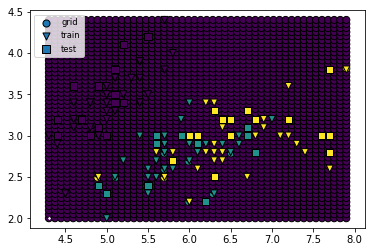

(2500, 2)


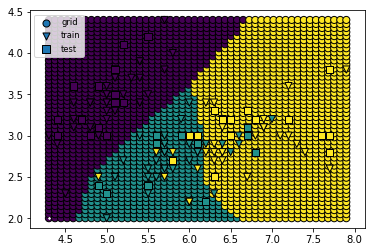

(2500, 2)


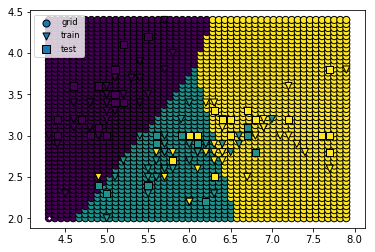

In [391]:
#4.3.b
sigmas=[0.002,.3,20]
for i in range(len(sigmas)):
    parzen_estimator2d_class1 = parzen_estimator(2,sigmas[i])
    parzen_estimator2d_class2 = parzen_estimator(2,sigmas[i])
    parzen_estimator2d_class3 = parzen_estimator(2,sigmas[i])

    parzen_estimator2d_class1.train(class1_train[:,input_dims[:2]])
    parzen_estimator2d_class2.train(class2_train[:,input_dims[:2]])
    parzen_estimator2d_class3.train(class3_train[:,input_dims[:2]])

    bayesparzen2d = classif_bayes_parzen([parzen_estimator2d_class1, parzen_estimator2d_class2, parzen_estimator2d_class3], [0.333,0.333,0.333])
    gridplot(bayesparzen2d, iris_train[:, input_dims + [-1]], iris_test[:, input_dims + [-1]], n_points=50, classifier_type='window')

In [317]:
log_prob_train=bayesparzen2d.compute_predictions(iris_train[:, input_dims[:2]])
log_prob_test=bayesparzen2d.compute_predictions(iris_test[:, input_dims[:2]])

classesPred_train = log_prob_train.argmax(1)+1
classesPred_test = log_prob_test.argmax(1)+1

print "Taux d'erreur (entrainement) %.2f%%" % ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
print "Taux d'erreur (test) %.2f%%" % ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

Taux d'erreur (entrainement) 15.24%
Taux d'erreur (test) 20.00%


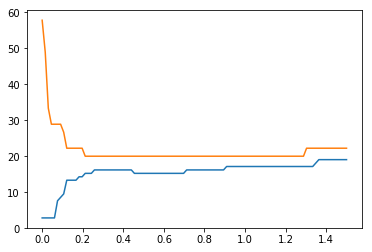

Optimal sigma value at minimum validation error:0.21220707070707071


In [392]:
#4.3.c
hs = np.linspace(0.0001,1.5,100)
train_error = np.zeros_like(hs)
validation_error = np.zeros_like(hs)
for i in range(len(hs)):
    #create each class's estimator
    parzen_estimator2d_class1 = parzen_estimator(2,hs[i])
    parzen_estimator2d_class2 = parzen_estimator(2,hs[i])
    parzen_estimator2d_class3 = parzen_estimator(2,hs[i])
    #train each estimator
    parzen_estimator2d_class1.train(class1_train[:,input_dims[:2]])
    parzen_estimator2d_class2.train(class2_train[:,input_dims[:2]])
    parzen_estimator2d_class3.train(class3_train[:,input_dims[:2]])
    #generate a bayes classifier for each estimator
    bayesparzen2d = classif_bayes_parzen([parzen_estimator2d_class1, parzen_estimator2d_class2, parzen_estimator2d_class3], [0.333,0.333,0.333])
    log_prob_train=bayesparzen2d.compute_predictions(iris_train[:, input_dims[:2]])
    log_prob_test=bayesparzen2d.compute_predictions(iris_test[:, input_dims[:2]])

    classesPred_train = log_prob_train.argmax(1)+1
    classesPred_test = log_prob_test.argmax(1)+1
    #determine and store each train and validation error
    train_error[i] = ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
    validation_error[i] = ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

pyplot.plot(hs,train_error)
pyplot.plot(hs,validation_error)
pyplot.show()
min_error = argmin(validation_error)
print 'Optimal sigma value at minimum validation error:' + repr(hs[min_error])

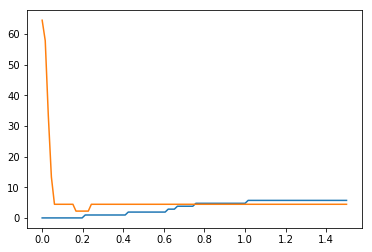

Optimal sigma value at minimum validation error:0.16675555555555555


In [393]:
#4.3.d
hs = np.linspace(0.0001,1.5,100)
train_error = np.zeros_like(hs)
validation_error = np.zeros_like(hs)
for i in range(len(hs)):
    parzen_estimator4d_class1 = parzen_estimator(4,hs[i])
    parzen_estimator4d_class2 = parzen_estimator(4,hs[i])
    parzen_estimator4d_class3 = parzen_estimator(4,hs[i])

    parzen_estimator4d_class1.train(class1_train[:,input_dims[:4]])
    parzen_estimator4d_class2.train(class2_train[:,input_dims[:4]])
    parzen_estimator4d_class3.train(class3_train[:,input_dims[:4]])

    bayesparzen4d = classif_bayes_parzen([parzen_estimator4d_class1, parzen_estimator4d_class2, parzen_estimator4d_class3], [0.333,0.333,0.333])
    log_prob_train=bayesparzen4d.compute_predictions(iris_train[:, input_dims[:4]])
    log_prob_test=bayesparzen4d.compute_predictions(iris_test[:, input_dims[:4]])

    classesPred_train = log_prob_train.argmax(1)+1
    classesPred_test = log_prob_test.argmax(1)+1
    
    train_error[i] = ((1-(classesPred_train==iris_train[:,-1]).mean())*100.0)
    validation_error[i] = ((1-(classesPred_test==iris_test[:,-1]).mean())*100.0)

pyplot.plot(hs,train_error)
pyplot.plot(hs,validation_error)
pyplot.show()
min_error = argmin(validation_error)
print 'Optimal sigma value at minimum validation error:' + repr(hs[min_error])